**Visualizing Model Interpretability: SHAP Waterfall Plots and Partial Dependence Plots**

Preprocessing and Model Training for Candidate Performance Prediction

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
df = pd.read_csv('updated_dataset.csv')

# Display column data types to identify non-numeric columns
print("Column Data Types:\n", df.dtypes)

# Drop the 'Name' column as it is a string and doesn't help in training
df = df.drop(columns=['Name'])

# Check and convert the 'Role' column to numeric if needed (Label Encoding)
if df['Role'].dtype == 'object':  # If 'Role' is categorical, encode it
    label_encoder = LabelEncoder()
    df['Role'] = label_encoder.fit_transform(df['Role'])

# One-Hot encode 'Reason for decision' if categorical (check if 'Reason for decision' is categorical)
if df['Reason for decision'].dtype == 'object':  # Assuming it's a categorical variable
    df = pd.get_dummies(df, columns=['Reason for decision'], drop_first=True)

# Handle the 'Transcript' column using TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # You can adjust the number of features
X_transcripts = tfidf_vectorizer.fit_transform(df['Transcript'].astype(str))

# Convert the sparse matrix to a DataFrame and concatenate it with the original data (excluding 'Transcript')
X_transcripts_df = pd.DataFrame(X_transcripts.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df = pd.concat([df.drop(columns=['Transcript']), X_transcripts_df], axis=1)

# Check the new data types after transformation
print("\nData Types After Transformation:\n", df.dtypes)

# Define your features (X) and target variable (y)
X = df.drop(columns=['Performance (select/reject)'])
y = df['Performance (select/reject)']

# Ensure there are no non-numeric columns left in X
X = X.apply(pd.to_numeric, errors='coerce')  # Convert any non-numeric columns to NaN

# Fill any NaN values with a specific strategy, for example using the median of each column
X = X.fillna(X.median())

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate model performance on test data
accuracy = model.score(X_test_scaled, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")


Column Data Types:
 ID                                int64
Name                             object
Role                             object
Transcript                       object
Resume                           object
Performance (select/reject)      object
Reason for decision              object
Job Description                  object
Resume_Transcript_Similarity    float64
Transcript_Length                 int64
Sentiment_Polarity              float64
Readability_Score               float64
Confidence_Score                float64
Response_Sentiment              float64
Technical_Confidence            float64
Clarity_Score                   float64
dtype: object

Data Types After Transformation:
 ID                               int64
Role                             int32
Resume                          object
Performance (select/reject)     object
Job Description                 object
                                ...   
worked                         float64
working           

D:\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count



Test Accuracy: 1.0000


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Cross-validation for better evaluation of the model
cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Score: {cross_val_scores.mean():.4f}")

# Predicting on test data
y_pred = model.predict(X_test_scaled)

# Classification Report and Confusion Matrix for performance evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Cross-Validation Scores: [1.     1.     1.     0.9875 1.    ]
Mean Cross-Validation Score: 0.9975

Classification Report:
               precision    recall  f1-score   support

    rejected       1.00      1.00      1.00        51
    selected       1.00      1.00      1.00        49

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


Confusion Matrix:
 [[51  0]
 [ 0 49]]


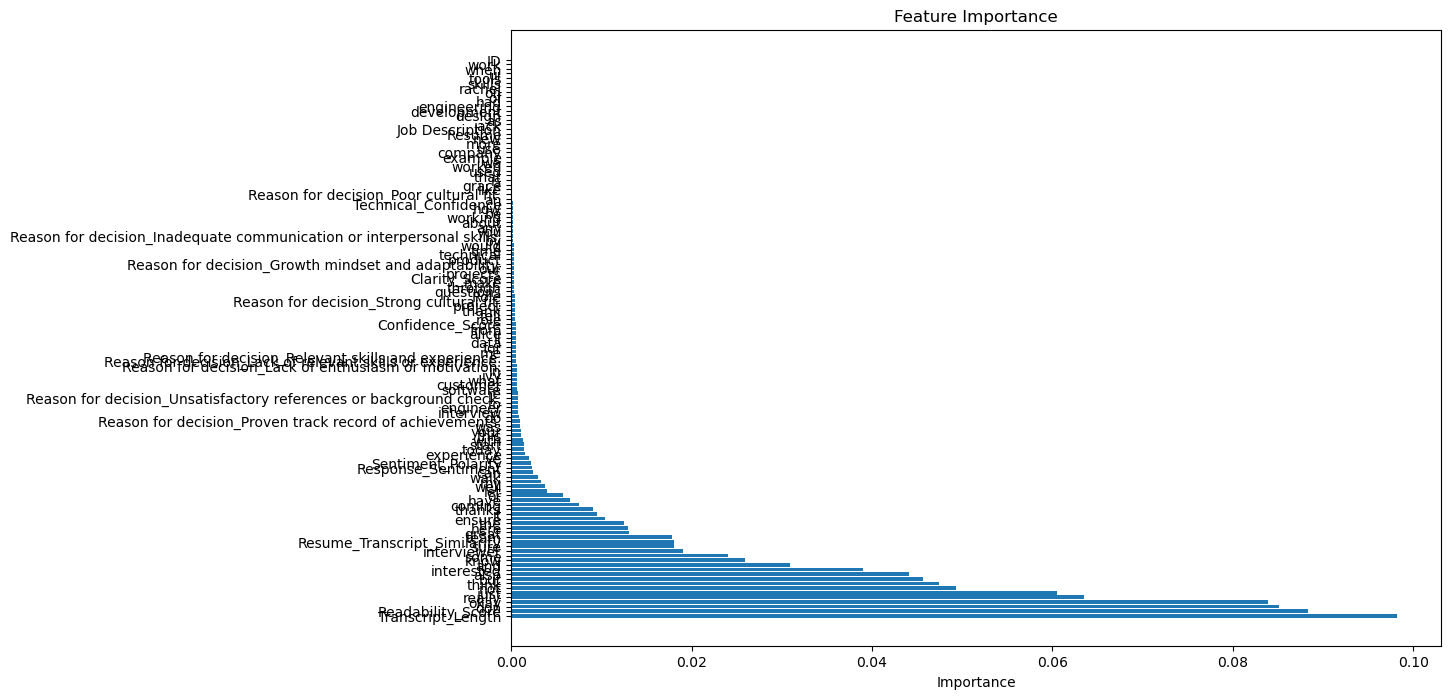

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the RandomForest model
importances = model.feature_importances_
indices = X.columns

# Sort the features by importance
sorted_indices = np.argsort(importances)[::-1]

# Plotting the feature importance
plt.figure(figsize=(12, 8))
plt.title("Feature Importance")
plt.barh(np.array(indices)[sorted_indices], importances[sorted_indices])
plt.xlabel("Importance")
plt.show()


Generating and Visualizing SHAP Waterfall Plots for Model Interpretability

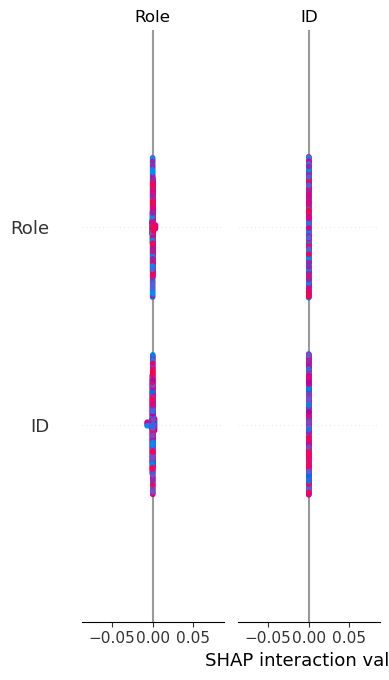

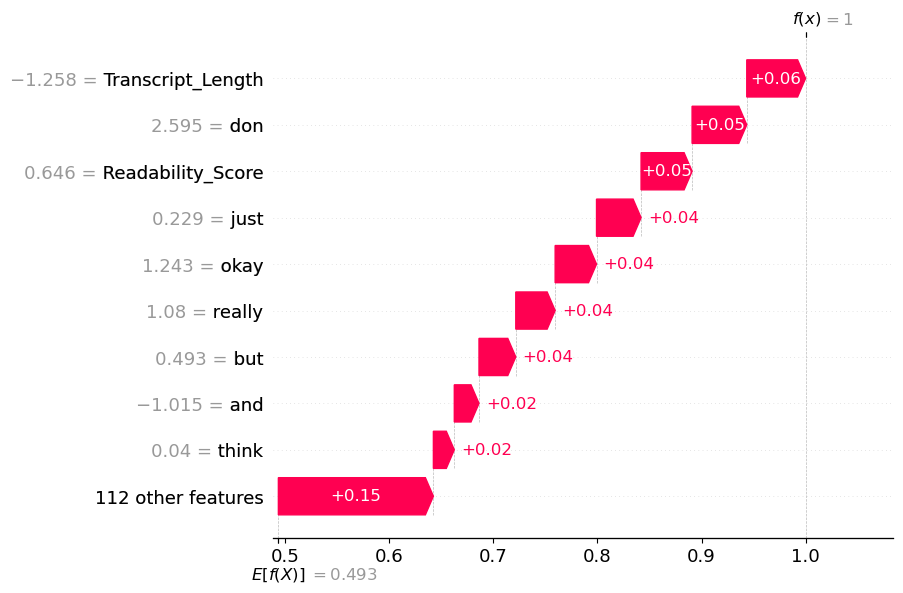

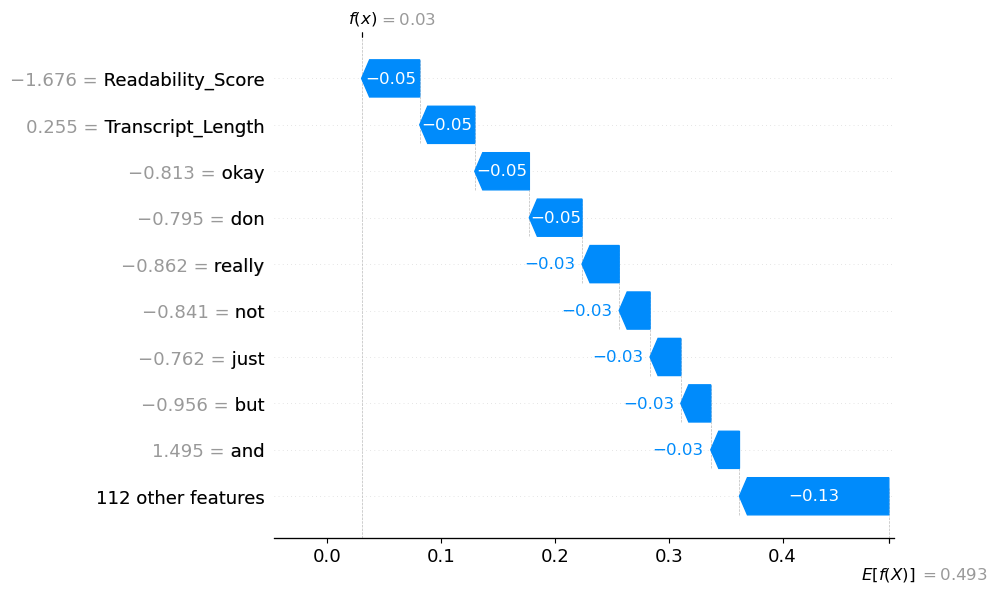

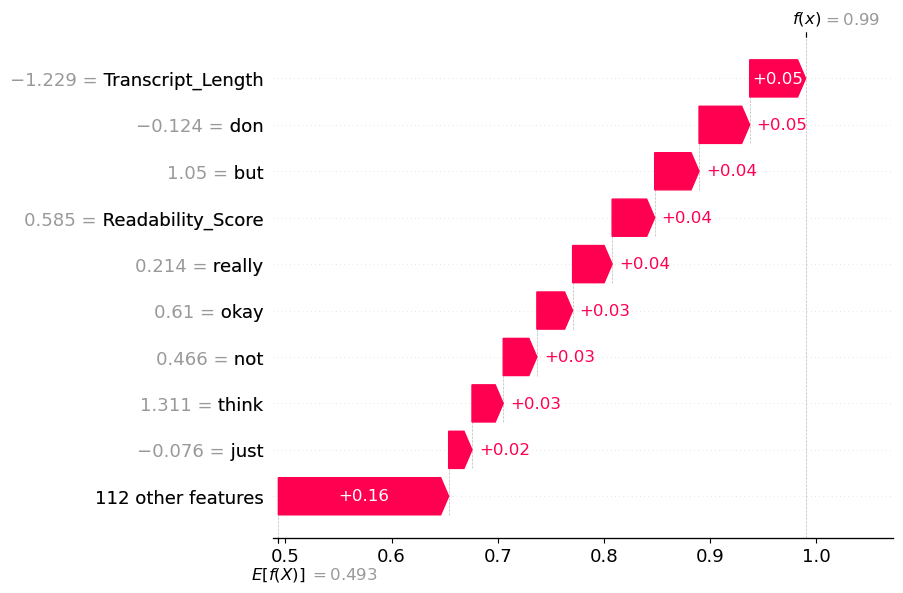

Waterfall plots saved as images:
 - waterfall_plot_low.png
 - waterfall_plot_medium.png
 - waterfall_plot_high.png


In [15]:
import pandas as pd
import shap
import matplotlib.pyplot as plt

# Create the SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for training data
shap_values = explainer.shap_values(X_train_scaled)
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns)

# Compute SHAP values for test data
shap_values_test = explainer.shap_values(X_test_scaled)

# Convert X_test_scaled to a DataFrame for compatibility with SHAP and pandas indexing
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Define target class (for example, index 0 for the first class, adjust as needed)
target_class = 0  # Adjust this based on the class you're interested in

# Define indices for low, medium, and high predictions
low_idx = 0  # Index for the lowest prediction
medium_idx = len(X_test_scaled_df) // 2  # Index for the middle prediction
high_idx = len(X_test_scaled_df) - 1  # Index for the highest prediction

# Create SHAP explanations and handle base_values properly
if isinstance(shap_values_test, shap.Explanation):
    # If shap_values is an Explanation object, directly access the explanations for the given indices
    low_explanation = shap_values_test[low_idx]
    medium_explanation = shap_values_test[medium_idx]
    high_explanation = shap_values_test[high_idx]
else:
    # If shap_values is an ndarray (for example in a multi-class classification), handle it manually
    low_explanation = shap.Explanation(
        values=shap_values_test[low_idx, :, target_class],
        data=X_test_scaled_df.iloc[low_idx],
        feature_names=X.columns,
        base_values=explainer.expected_value[target_class]  # Set base_value manually
    )
    medium_explanation = shap.Explanation(
        values=shap_values_test[medium_idx, :, target_class],
        data=X_test_scaled_df.iloc[medium_idx],
        feature_names=X.columns,
        base_values=explainer.expected_value[target_class]  # Set base_value manually
    )
    high_explanation = shap.Explanation(
        values=shap_values_test[high_idx, :, target_class],
        data=X_test_scaled_df.iloc[high_idx],
        feature_names=X.columns,
        base_values=explainer.expected_value[target_class]  # Set base_value manually
    )

# Function to generate and save waterfall plots
def generate_waterfall_plot(explanation, title, filename, max_display=10):
    if explanation is None:
        raise ValueError(f"Explanation for {title} is None. Cannot generate plot.")
    plt.figure(figsize=(10, 5))  # Set the figure size
    shap.waterfall_plot(explanation, max_display=max_display)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)  # Save the plot to a file
    plt.close()

# Generate and save waterfall plots
generate_waterfall_plot(low_explanation, "Low Prediction Waterfall Plot", "waterfall_plot_low.png")
generate_waterfall_plot(medium_explanation, "Medium Prediction Waterfall Plot", "waterfall_plot_medium.png")
generate_waterfall_plot(high_explanation, "High Prediction Waterfall Plot", "waterfall_plot_high.png")

print("Waterfall plots saved as images:")
print(" - waterfall_plot_low.png")
print(" - waterfall_plot_medium.png")
print(" - waterfall_plot_high.png")


Summary

1.Create SHAP Explainer: Generates SHAP values for model predictions.

2.Compute SHAP Values: Calculate SHAP values for both training and test data.

3.Visualize Feature Importance: Plot summary of SHAP values for feature importance.

4.Select Test Data Instances: Choose low, medium, and high prediction instances.

5.Generate SHAP Explanations: Create explanations for selected test instances.

6.Handle SHAP Data: Process SHAP values based on data type (Explanation or ndarray).

7.Generate Waterfall Plots: Visualize feature impact for selected instances with waterfall plots.

8.Save Waterfall Plots: Save the generated plots as PNG images for further analysis.

Analyzing Model Behavior with Partial Dependence Plots (PDPs)

Generating 1D PDPs...


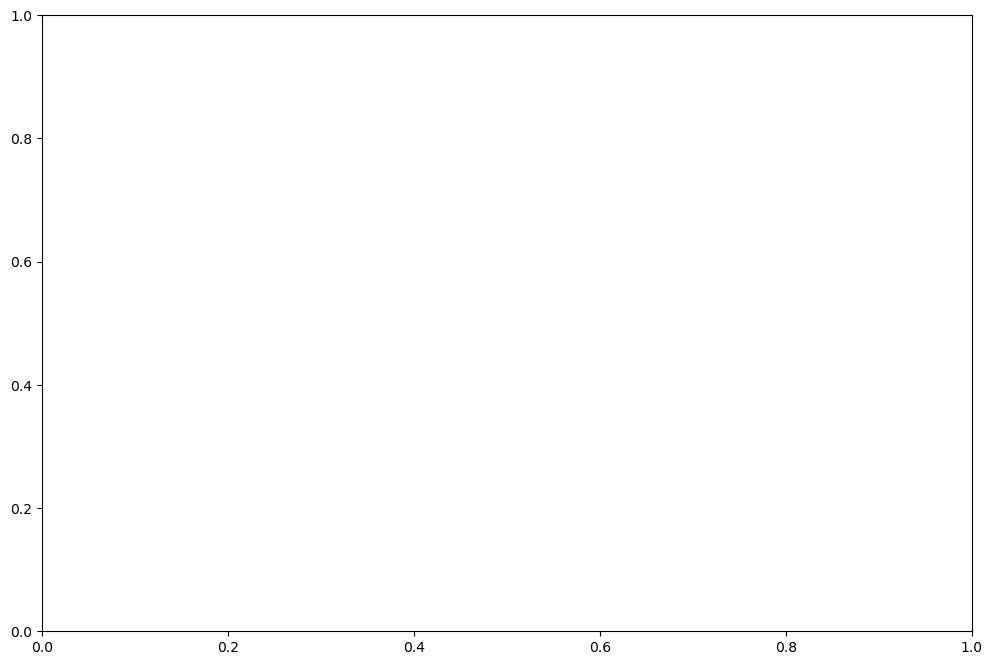

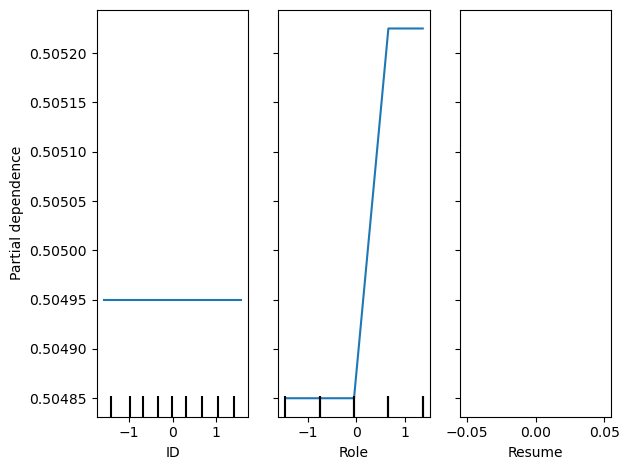

Generating 2D PDP...


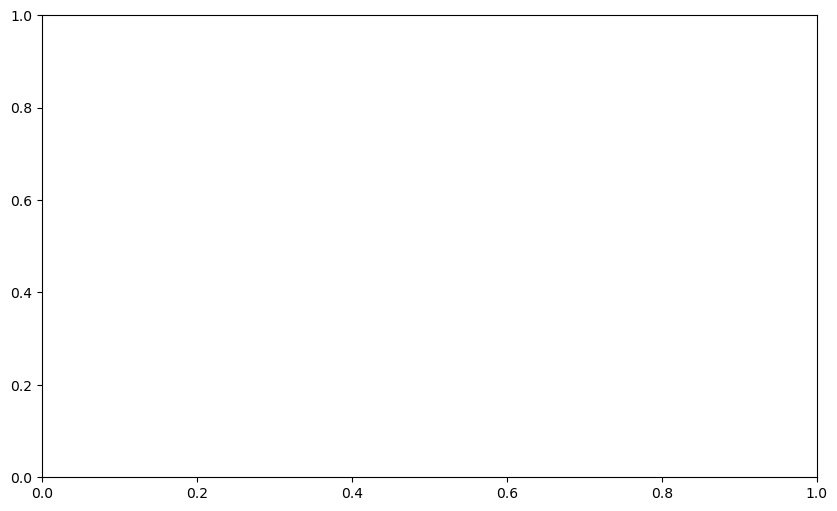

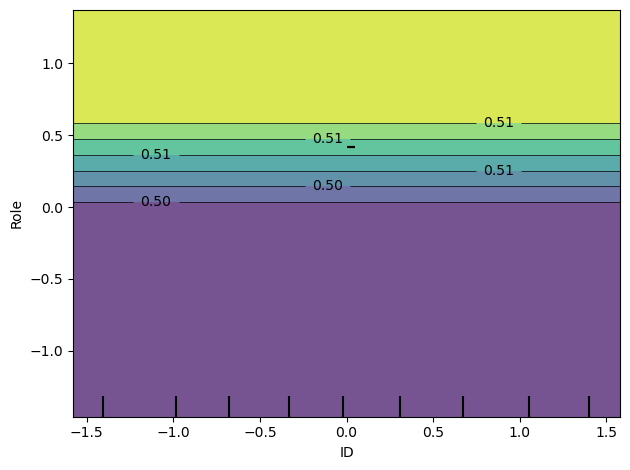

In [7]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Features to analyze for 1D PDP
features_to_plot = [0, 1, 2]  # Replace with the indices or names of your features

# Generate 1D Partial Dependence Plots
print("Generating 1D PDPs...")
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    model,
    X_train_scaled,
    features=features_to_plot,
    feature_names=X.columns.tolist(),
    kind="average"
)
plt.tight_layout()
plt.show()

# Generate 2D Partial Dependence Plot for two features
print("Generating 2D PDP...")
feature_pair = (0, 1)  # Replace with two feature indices/names
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    model,
    X_train_scaled,
    features=[feature_pair],
    feature_names=X.columns.tolist(),
    kind="average"
)
plt.tight_layout()
plt.show()


Summary

1.1D Partial Dependence Plot (PDP): Visualize the relationship between individual features and the target variable.

2.Select Features: Choose specific feature indices (e.g., 0, 1, 2) for analysis.

3.Generate 1D PDP: Display 1D PDP for selected features using PartialDependenceDisplay.

4.2D Partial Dependence Plot: Analyze the interaction between two features and the target.

5.Select Feature Pair: Choose a pair of features for the 2D PDP (e.g., features 0 and 1).

6.Generate 2D PDP: Visualize the interaction between the selected feature pair and the target.

7.Display Plots: Show the generated plots using plt.show().